In [1]:
!pip install piqa

In [22]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import torch
import tensorflow as tf

import torch.nn as nn
import os
from torchvision.utils import *
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
import cv2
import pandas as pd
import tqdm
import seaborn as sns

In [3]:
if torch.cuda.is_available():
    cuda = 1
else :
    cuda = 0

epochs = 100

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28,1000)
        self.fc2 = nn.Linear(1000, 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2,1000)
        self.fc2 = nn.Linear(1000, 28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        
        out = self.relu(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(2,500)
        self.fc2 = nn.Linear(500, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        
        out = self.relu(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out

In [10]:
encoder_model = Encoder()
decoder_model = Decoder()
discriminator_model= Discriminator()   

if torch.cuda.is_available():
    encoder_model= encoder_model.cuda()
    decoder_model= decoder_model.cuda()
    discriminator_model= discriminator_model.cuda()
    
gen_lr, reg_lr = 0.0001, 0.00005
enc_opt = torch.optim.Adam(encoder_model.parameters(), lr=gen_lr)
dec_opt = torch.optim.Adam(decoder_model.parameters(), lr=gen_lr)
disc_opt = torch.optim.Adam(discriminator_model.parameters(), lr=reg_lr)

In [36]:
!pip install pytorch-msssim
from pytorch_msssim import ssim

def BCE(input_x,target):
    loss = nn.functional.binary_cross_entropy(input_x,target)
    return loss

def MSE(input_x,target):
    loss = nn.functional.mse_loss(input_x,target)
    return loss

def ssim_loss(input_x,target):
    X = torch.reshape(input_x,(input_x.shape[0],1,28,28))
    y = torch.reshape(target,(target.shape[0],1,28,28))
    ssim_loss = 1 - ssim(X, y, data_range=1, size_average=True)
    
    
    return ssim_loss

In [13]:
def print_loss(epoch, D_loss_gauss, G_loss, recon_loss):
    print('Epoch-{}; D_loss_gauss: {:.4}; G_loss: {:.4}; recon_loss: {:.4}'.format(epoch, D_loss_gauss,
                                                                                   G_loss, recon_loss))

In [44]:
def train(dec, enc, disc, dec_opt, enc_opt, enc_generator,disc_opt, data_loader,loss):
    enc.train()
    dec.train()
    disc.train()

    for X, target in data_loader:
        if(X.shape[0]!=64):
            break
        X_dim = X.shape[2]*X.shape[3]
        train_batch_size = X.shape[0]
        X.resize_(train_batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        if cuda:
            X, target = X.cuda(), target.cuda()

        dec.zero_grad()
        enc.zero_grad()
        disc.zero_grad()

        latent_var = enc(X)
        recon_img = dec(latent_var)
        recon_loss = loss(recon_img, torch.reshape(X,(train_batch_size, X_dim)))

        recon_loss.backward()
        dec_opt.step()
        enc_opt.step()

        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()

        enc.eval()
        lat_gauss = Variable(torch.randn(train_batch_size, 2) * 5.)
        if cuda:
            lat_gauss = lat_gauss.cuda()

        lat_enc = enc(X)

        D_real_gauss = disc(lat_gauss)
        D_fake_gauss = disc(lat_enc)

        D_loss = -torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss))

        D_loss.backward()
        disc_opt.step()

        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()

        # Generator
        enc.train()
        lat_enc = enc(X)

        D_fake_gauss = disc(lat_enc)
        G_loss = -torch.mean(torch.log(D_fake_gauss))

        G_loss.backward()
        enc_generator.step()

        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()
        
        #Eval accuracy
        disc.eval()
        pred = disc(enc(X))
        acc = (pred.reshape(-1).detach().cpu().numpy().round() == np.ones(train_batch_size)).mean()
        
    return D_loss, G_loss, recon_loss, acc

In [45]:
def generate_model(train_dataloader,loss):
    generator_loss = []
    discriminator_loss = []
    reconstruction_loss = []  
    accuracy = []
    
    torch.manual_seed(10)

    if cuda:
        enc = Encoder().cuda()
        dec = Decoder().cuda()
        disc = Discriminator().cuda()
    else:
        enc = Encoder()
        dec = Decoder()
        disc = Discriminator()

    # Set learning rates
    gen_lr = 0.0001
    reg_lr = 0.00005

    # Set optimizators
    dec_opt = torch.optim.Adam(dec.parameters(), lr=gen_lr)
    enc_opt = torch.optim.Adam(enc.parameters(), lr=gen_lr)

    enc_generator = torch.optim.Adam(enc.parameters(), lr=gen_lr)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=reg_lr)

    for epoch in range(epochs):
        D_loss, G_loss, recon_loss, acc = train(dec, enc, disc, dec_opt, enc_opt, enc_generator,disc_opt, train_dataloader,loss)
        discriminator_loss.append(D_loss.item())
        generator_loss.append(G_loss.item())
        reconstruction_loss.append(recon_loss.item())
        accuracy.append(acc)
        
        if epoch % 10 == 0:
            print_loss(epoch, D_loss.item(), G_loss.item(), recon_loss.item())
        

    return enc, dec, generator_loss, discriminator_loss , reconstruction_loss, accuracy

In [47]:
Q, P, bce_gloss, bce_dloss, bce_rloss, bce_acc = generate_model(train_dataloader, BCE)

Epoch-0; D_loss_gauss: 0.9761; G_loss: 0.8008; recon_loss: 0.3074
Epoch-10; D_loss_gauss: 0.6373; G_loss: 1.415; recon_loss: 0.2647
Epoch-20; D_loss_gauss: 0.6712; G_loss: 1.502; recon_loss: 0.2758
Epoch-30; D_loss_gauss: 0.6355; G_loss: 1.533; recon_loss: 0.2591
Epoch-40; D_loss_gauss: 0.6241; G_loss: 1.582; recon_loss: 0.2703
Epoch-50; D_loss_gauss: 0.5498; G_loss: 1.553; recon_loss: 0.2694
Epoch-60; D_loss_gauss: 0.4831; G_loss: 1.551; recon_loss: 0.2555
Epoch-70; D_loss_gauss: 0.6263; G_loss: 1.579; recon_loss: 0.2649
Epoch-80; D_loss_gauss: 0.4055; G_loss: 1.569; recon_loss: 0.2625
Epoch-90; D_loss_gauss: 0.6197; G_loss: 1.593; recon_loss: 0.2659


#Q1: Plot a sample of generated image and real image for all 0-9 digits

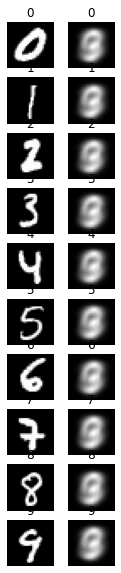

In [48]:
#a 

figure = plt.figure(figsize=(2, 10))
cols, rows = 2,10

for i in range(0,rows):
    labels = training_data.targets.numpy()
    sample_idx = np.random.choice(np.where(labels==i)[0])
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, 2*i+1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    figure.add_subplot(rows, cols, 2*i+2)
    plt.title(labels_map[label])
    plt.axis("off")
    img = torch.unsqueeze(img,0)
    if cuda:
        img = img.to(device='cuda')
    lat_var = Q(img)
    gen_img = torch.reshape(P(lat_var),(28,28)).detach().cpu()
    plt.imshow(gen_img, cmap="gray")
plt.show()

Epoch-0; D_loss_gauss: 1.185; G_loss: 0.8591; recon_loss: 0.7994
Epoch-10; D_loss_gauss: 1.013; G_loss: 1.038; recon_loss: 0.6965
Epoch-20; D_loss_gauss: 0.9359; G_loss: 1.055; recon_loss: 0.7081
Epoch-30; D_loss_gauss: 0.9129; G_loss: 1.047; recon_loss: 0.6929
Epoch-40; D_loss_gauss: 1.169; G_loss: 1.094; recon_loss: 0.7453
Epoch-50; D_loss_gauss: 0.9175; G_loss: 1.077; recon_loss: 0.7499
Epoch-60; D_loss_gauss: 0.8252; G_loss: 1.07; recon_loss: 0.6831
Epoch-70; D_loss_gauss: 0.869; G_loss: 1.062; recon_loss: 0.6573
Epoch-80; D_loss_gauss: 0.8957; G_loss: 1.08; recon_loss: 0.6687
Epoch-90; D_loss_gauss: 0.9818; G_loss: 1.093; recon_loss: 0.789


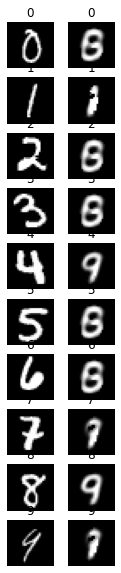

In [49]:
#b 
Q, P, ssim_gloss, ssim_dloss, ssim_rloss, ssim_acc = generate_model(train_dataloader, ssim_loss)

figure = plt.figure(figsize=(2, 10))
cols, rows = 2,10

for i in range(0,rows):
    labels = training_data.targets.numpy()
    sample_idx = np.random.choice(np.where(labels==i)[0])
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, 2*i+1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    figure.add_subplot(rows, cols, 2*i+2)
    plt.title(labels_map[label])
    plt.axis("off")
    img = torch.unsqueeze(img,0)
    if cuda:
        img = img.to(device='cuda')
    lat_var = Q(img)
    gen_img = torch.reshape(P(lat_var),(28,28)).detach().cpu()
    plt.imshow(gen_img, cmap="gray")
plt.show()

Epoch-0; D_loss_gauss: 0.9761; G_loss: 0.8008; recon_loss: 0.07398
Epoch-10; D_loss_gauss: 0.6373; G_loss: 1.415; recon_loss: 0.06831
Epoch-20; D_loss_gauss: 0.6712; G_loss: 1.502; recon_loss: 0.07232
Epoch-30; D_loss_gauss: 0.6355; G_loss: 1.533; recon_loss: 0.06665
Epoch-40; D_loss_gauss: 0.6241; G_loss: 1.582; recon_loss: 0.07006
Epoch-50; D_loss_gauss: 0.5497; G_loss: 1.553; recon_loss: 0.06948
Epoch-60; D_loss_gauss: 0.4831; G_loss: 1.551; recon_loss: 0.06507
Epoch-70; D_loss_gauss: 0.6263; G_loss: 1.579; recon_loss: 0.06834
Epoch-80; D_loss_gauss: 0.4055; G_loss: 1.569; recon_loss: 0.06675
Epoch-90; D_loss_gauss: 0.6197; G_loss: 1.593; recon_loss: 0.06799


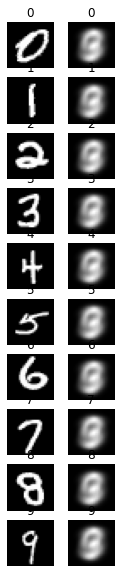

In [51]:
#c
Q, P, mse_gloss, mse_dloss, mse_rloss, mse_acc = generate_model(train_dataloader,MSE)

figure = plt.figure(figsize=(2, 10))
cols, rows = 2,10

for i in range(0,rows):
    labels = training_data.targets.numpy()
    sample_idx = np.random.choice(np.where(labels==i)[0])
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, 2*i+1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    figure.add_subplot(rows, cols, 2*i+2)
    plt.title(labels_map[label])
    plt.axis("off")
    img = torch.unsqueeze(img,0)
    if cuda:
        img = img.to(device='cuda')
    lat_var = Q(img)
    gen_img = torch.reshape(P(lat_var),(28,28)).detach().cpu()
    plt.imshow(gen_img, cmap="gray")
plt.show()

#Q2: Plot the reconstruction loss and discriminator loss over all the epochs in one graph

Discrimator loss increases initially and almost remain constant whereas reconstruction loss decress with epoch. Weigths of encoder and decoder are so as trained such that decoder tries to output the same input image taking output of encoder so as model trains reconstruction loss decreases. Discriminator tries to discriminate the output encoder generates and random gaussian sample as the encoder learns to generate samples like gaussian distribution discriminator fails to identify real and fake input so loss of discriminator remains almost constant.


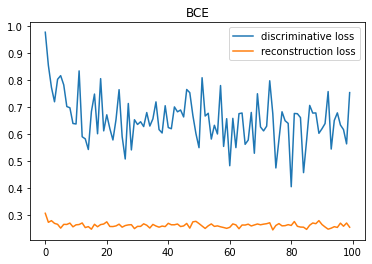

In [52]:
#a
plt.plot(bce_dloss, label="discriminative loss")
plt.plot(bce_rloss, label="reconstruction loss")
plt.legend()
plt.title('BCE')
plt.show()

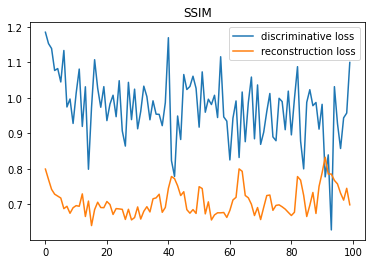

In [53]:
#b
plt.plot(ssim_dloss, label="discriminative loss")
plt.plot(ssim_rloss, label="reconstruction loss")
plt.legend()
plt.title('SSIM')
plt.show()

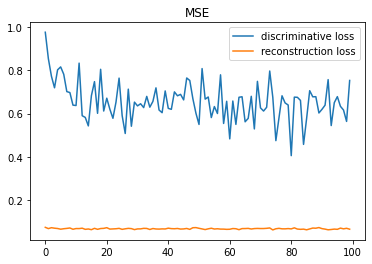

In [54]:
#c
plt.plot(mse_dloss, label="discriminative loss")
plt.plot(mse_rloss, label="reconstruction loss")
plt.legend()
plt.title('MSE')
plt.show()

#Q3:

Here the Vanilla Autoencoder is a neural network that is trained to produce an output which is very similar to its input trained in an unsupervised manner, without the labels.

1. Encoder: It takes in an input x and produces an output h (intermediate state). Here, the encoder can take in an image x of size 28 x 28 and produce an output h of size 2 x 1. The encoder in this case just compresses the image such that it’ll occupy a lower dimensional space, on doing so we can now see that h could be stored using less memory than directly storing the image x.

2. Decoder: It takes in the output of an encoder h and tries to reconstruct the input at its output. Here, h is of size 2 x 1, the decoder tries to get back the original 28 x 28 image using h. We’ll train the decoder to get back as much information as possible from h to reconstruct x.

The Discriminator is feed with real gaussian sample and output of discriminator is set to 1 and output of encoderare feed to discriminator keeping target to 0 so that discriminator learns to classify real and fake input of gaussian distribution

Weigths of encoder are trained such that discriminator identifies it to be true thus encoder learns to output in given distribution
latent variable produced by encoder is feed to decoder to generate image

#Q4. Plot the training accuracy and loss values for all the 3 loss functions as 2 separate plots

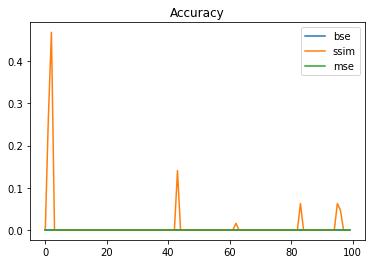

In [55]:
plt.plot(bce_acc, label='bse')
plt.plot(ssim_acc, label='ssim')
plt.plot(mse_acc, label='mse')
plt.legend()
plt.title("Accuracy")
plt.show()

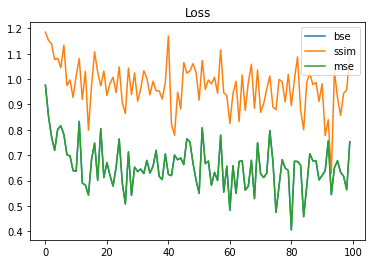

In [56]:
plt.plot(bce_dloss, label='bse')
plt.plot(ssim_dloss, label='ssim')
plt.plot(mse_dloss, label='mse')
plt.legend()
plt.title("Loss")
plt.show()

#Q5

Losses perform equally but BCE in intial training epoch showed better performance, 

In middle and ending stage of training loss is almost same and constant for all 3 loses. 

Also from accuracy plot BCE has highest accuracy out of all other Losses so BCE is favourable